In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### Loading Data & checking for missing Values

In [4]:
#load asset data
asset_details =pd.read_csv('C://Users//archi//OneDrive - purdue.edu//ML Final Project//asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [5]:
#checking for null rows in each column
asset_details.isnull().sum()

Asset_ID      0
Weight        0
Asset_Name    0
dtype: int64

In [6]:
train = pd.read_csv('C://Users//archi//OneDrive - purdue.edu//ML Final Project//train.csv')
train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [7]:
#checking for null rows in each column

#train.value_counts() 
train.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [8]:
##checking total missing values in individual asset class

t=train.groupby('Asset_ID').apply(lambda x: x.isnull().sum()).sort_values(by='Target', ascending=True)
t=t[['Target']]
t.reset_index(inplace=True)
t

,Asset_ID,Target
0,1,304
1,6,340
2,9,521
3,5,2302
4,2,4861
5,7,9326
6,0,13415
7,3,18731
8,13,21014
9,10,40025


In [9]:
## checking total rows of each asset class

t1 = train.groupby('Asset_ID').size()
# Convert the Series to a DataFrame
t1 = pd.DataFrame(t1, columns=['Count'])
# Reset index to turn the 'Asset_ID' into a regular column
t1.reset_index(inplace=True)
# Display the DataFrame
print(t1)

    Asset_ID    Count
0          0  1942619
1          1  1956282
2          2  1953537
3          3  1791867
4          4  1156866
5          5  1955140
6          6  1956200
7          7  1951127
8          8  1592071
9          9  1956030
10        10   670497
11        11  1701261
12        12  1778749
13        13  1874560


### Deciding on a single cryptocurrency to reduce size of data for better analysis

In [11]:
# Comparing missing values count ('Target') & the total counts of each asset
merged_df = pd.merge(t, t1, on='Asset_ID', how='inner')
merged_df=pd.merge(merged_df,asset_details, on='Asset_ID', how='inner').sort_values('Target')
merged_df

,Asset_ID,Target,Count,Weight,Asset_Name
0,1,304,1956282,6.779922,Bitcoin
1,6,340,1956200,5.894403,Ethereum
2,9,521,1956030,2.397895,Litecoin
3,5,2302,1955140,1.386294,EOS.IO
4,2,4861,1953537,2.397895,Bitcoin Cash
5,7,9326,1951127,2.079442,Ethereum Classic
6,0,13415,1942619,4.304065,Binance Coin
7,3,18731,1791867,4.406719,Cardano
8,13,21014,1874560,1.791759,TRON
9,10,40025,670497,1.098612,Maker


## Decided on Bitcoin given the lowest missing rows & high number of rows and weight.

In [12]:
b=train[train['Asset_ID']==1]
bit=pd.merge(b,asset_details, on='Asset_ID', how='inner')
bit.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,Asset_Name
0,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,6.779922,Bitcoin
1,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,6.779922,Bitcoin
2,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,6.779922,Bitcoin
3,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,6.779922,Bitcoin
4,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,6.779922,Bitcoin


#### checkpoint1: saving only bitcoin data from training set

In [ ]:
bit.to_csv('C://Users//archi//OneDrive - purdue.edu//ML Final Project//Bitcoin.csv',index=False)

### Addressing the 304 missing rows via interpolation

In [18]:
bit.sort_values(by='timestamp', inplace=True)
bit2=bit

In [19]:
# Linear Interpolation
bit2['Target'] = bit2['Target'].interpolate(method='linear', limit_direction='both')
 
# Interpolate missing values in the 'Target' column
bit2['Target'] = bit2['Target'].interpolate(method='polynomial', order=2, limit_direction='both')
 
# Print the count of NaN values after interpolation
print("Number of NaN values in Target after interpolation:", bit['Target'].isna().sum())
 
# Assuming 'train' is your DataFrame
rows_with_nan = bit2[bit2['Target'].isna()]

Number of NaN values in Target after interpolation: 0


### Feature Engineering - adding new features to improve model performance

In [20]:
# Convert timestamp to date & time columns
bit2['DateTime'] = pd.to_datetime(bit2['timestamp'], unit='s')
bit2['Date'] = bit2['DateTime'].dt.date
bit2['Hour'] = bit2['DateTime'].dt.hour
bit2['Minute'] = bit2['DateTime'].dt.minute
bit2['DayOfWeek'] = bit2['DateTime'].dt.dayofweek
 
# Price change features
bit2['PriceChange'] = bit2['Close'].pct_change()
 
# Moving averages
bit2['SMA_30min'] = bit2['Close'].rolling(window=30).mean()
bit2['EMA_30min'] = bit2['Close'].ewm(span=30, min_periods=0, adjust=False).mean()
 
# Lagged features
bit2['Close_Lagged_1'] = bit2['Close'].shift(1)
# Calculate volatility per hour
hourly_volatility = bit2.groupby(['Date','Hour','Minute']).agg(lambda x: x.max() - x.min())
hourly_volatility['Volatility'] = hourly_volatility['High'] - hourly_volatility['Low']

# Merge volatility back to the original DataFrame
bit2 = bit2.merge(hourly_volatility['Volatility'], on=['Date','Hour','Minute'], how='left')
bit2.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,DateTime,Date,Hour,Minute,DayOfWeek,PriceChange,SMA_30min,EMA_30min,Close_Lagged_1,Volatility
0,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,...,2018-01-01 00:01:00,2018-01-01,0,1,0,NaN,NaN,13850.176000,NaN,0.0
1,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,...,2018-01-01 00:02:00,2018-01-01,0,2,0,-0.001594,NaN,13848.751871,13850.176,0.0
2,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,...,2018-01-01 00:03:00,2018-01-01,0,3,0,-0.001937,NaN,13845.691363,13828.102,0.0
3,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,...,2018-01-01 00:04:00,2018-01-01,0,4,0,-0.002411,NaN,13840.681598,13801.314,0.0
4,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,...,2018-01-01 00:05:00,2018-01-01,0,5,0,-0.003132,NaN,13833.212721,13768.040,0.0


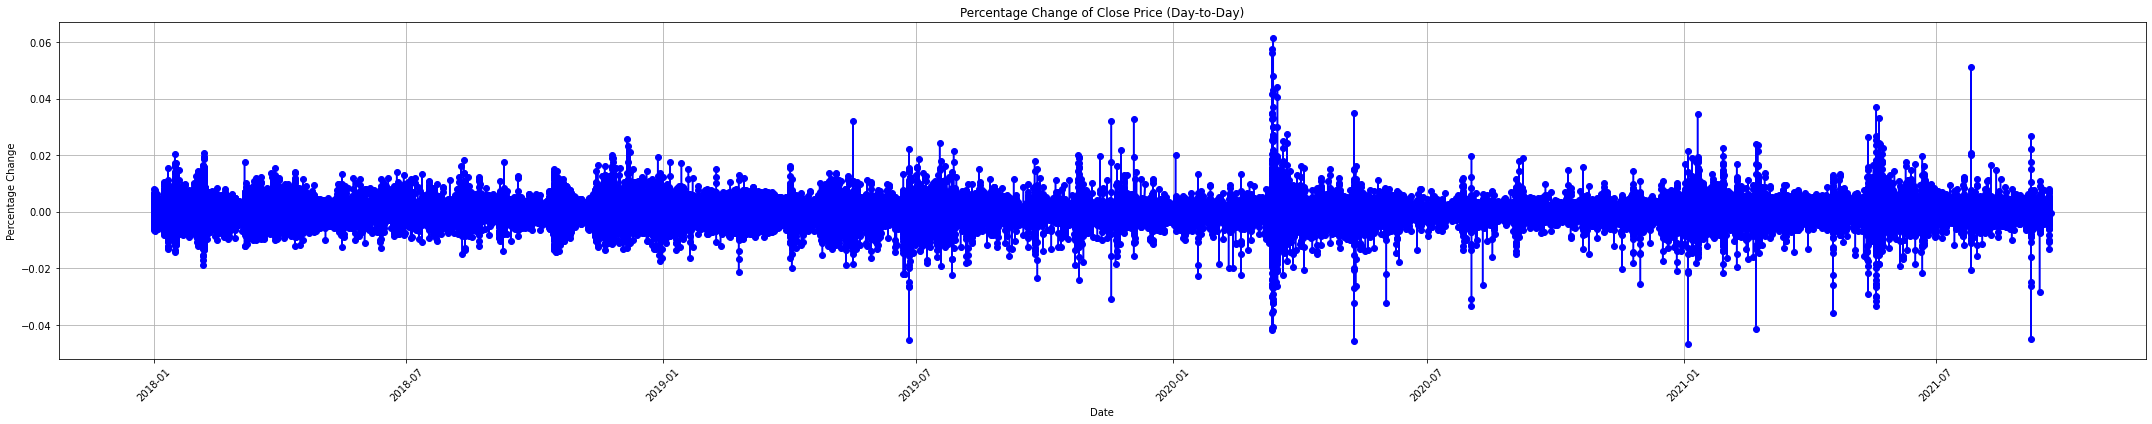

In [22]:
# Plot the percentage change over time
plt.figure(figsize=(30, 6))
plt.plot(bit2['Date'], bit2['PriceChange'], color='blue', marker='o', linestyle='-')
plt.title('Percentage Change of Close Price (Day-to-Day)')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Filtering Data: utlising only features of interest

#### Filtering to obtain the last closing price of each hour

In [16]:
# Filter rows where minute is 59
bit2 = bit2[bit2['Minute'] == 59]
# Select required columns
bit2 = bit2[['Close', 'Volume', 'Target', 'Weight', 'PriceChange', 'SMA_30min']]

In [ ]:
bit2.to_csv("C://Users//archi//OneDrive - purdue.edu//ML Final Project//bitcoin2.csv")

#### checkpoint 2: dataset with only required columns and last traded price (close) of each hour

In [6]:
#new_bit=pd.read_csv('C://Users//archi//OneDrive - purdue.edu//ML Final Project//bitcoin2.csv')
new_bit=bit2
new_bit.head()

,Unnamed: 0,Close,Volume,Target,Weight,PriceChange,SMA_30min
0,58,13646.514,34.515685,-0.004737,6.779922,0.001982,13650.339533
1,118,13336.952,68.531167,0.005604,6.779922,-0.000680,13482.989802
2,178,13413.472,23.738532,0.006756,6.779922,-0.001255,13379.308472
3,238,13496.986,21.688600,-0.007156,6.779922,0.000772,13564.058898
4,298,13653.062,45.471002,-0.003783,6.779922,0.001032,13596.469017


In [21]:
# checking limit for 
print(new_bit['Close'].mean()*0.05)

780.5824014938353


### Final Model 

Epoch 1/250
652/652 [==============================] - 68s 98ms/step - loss: 416266976.0000 - val_loss: 369359520.0000
Epoch 2/250
652/652 [==============================] - 62s 95ms/step - loss: 269558624.0000 - val_loss: 253735280.0000
Epoch 3/250
652/652 [==============================] - 62s 95ms/step - loss: 228697456.0000 - val_loss: 244658720.0000
Epoch 4/250
652/652 [==============================] - 61s 94ms/step - loss: 225905968.0000 - val_loss: 244018624.0000
Epoch 5/250
652/652 [==============================] - 62s 95ms/step - loss: 227075968.0000 - val_loss: 244126160.0000
Epoch 6/250
652/652 [==============================] - 62s 96ms/step - loss: 226628752.0000 - val_loss: 244099840.0000
Epoch 7/250
652/652 [==============================] - 62s 95ms/step - loss: 226879056.0000 - val_loss: 244317072.0000
Epoch 8/250
652/652 [==============================] - 63s 96ms/step - loss: 227097296.0000 - val_loss: 244466960.0000
Epoch 9/250
652/652 [===========================

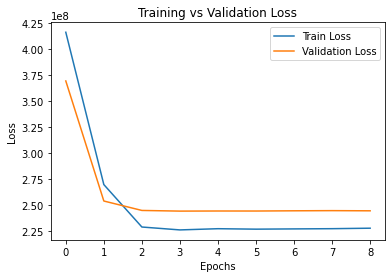

In [12]:
# Assuming new_bit is your DataFrame containing Bitcoin data
# Assuming 'Target' column is the third from the end
target_column_index = 1

# Define the sequence length
seq_len = 25

# Reshape data into sequences for Bitcoin (BTC) data
X_new_bit_train_seq = []
y_new_bit_train_seq = []

# Iterate over the DataFrame to create sequences
for i in range(len(new_bit) - seq_len):
    X_new_bit_train_seq.append(new_bit.iloc[i:i+seq_len, :-1].values)  # Excluding the last column (Target)
    y_new_bit_train_seq.append(new_bit.iloc[i+seq_len, target_column_index])

# Convert lists to numpy arrays
X_new_bit_train_seq = np.array(X_new_bit_train_seq)
y_new_bit_train_seq = np.array(y_new_bit_train_seq)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new_bit_train_seq, y_new_bit_train_seq, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Define the LSTM model architecture with increased model capacity and reduced regularization
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(seq_len, X_train.shape[2])))  # Increased number of units
model.add(Dropout(0.3))  # Decreased dropout rate
model.add(LSTM(256, return_sequences=True))  # Increased number of units
model.add(Dropout(0.3))  # Decreased dropout rate
model.add(LSTM(128))  # Increased number of units
model.add(Dropout(0.3))  # Decreased dropout rate
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Decreased dropout rate
model.add(Dense(1))

optimizer = Adam(lr=0.0001)  # Decrease learning rate
# Compile the model
model.compile(loss='mse', optimizer=optimizer)

# Define early stopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

# Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=250,
                    batch_size=32,  # Increase batch size
                    validation_split=0.2,
                    callbacks=[earlystop])

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate predicted values
y_pred = model.predict(X_test)

# Denormalize the predicted and actual values
predicted_denormalized = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred), axis=1))[:, -1]
actual_denormalized = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_denormalized, predicted_denormalized))

# Calculate MAE
mae = mean_absolute_error(actual_denormalized, predicted_denormalized)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')

204/204 [==============================] - 7s 36ms/step
Test RMSE: 18.0250089954737
Test MAE: 13.52026364690084
